# 🌳 Decision Predicate Graph (DPG)
This notebook shows a minimal working example of using DPG on **iris** dataset.


In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from dpg.core import DecisionPredicateGraph
from dpg.visualizer import plot_dpg

#### Training iris

In [2]:
# Load the iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Fit the model
model = RandomForestClassifier(n_estimators=10, random_state=27)
model.fit(X, y)

RandomForestClassifier(n_estimators=10, random_state=27)

#### Extracting DPG


Starting DPG extraction *****************************************
Model Class: RandomForestClassifier
Model Class Module: sklearn.ensemble._forest
Model Estimators:  10
Model Params:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 27, 'verbose': 0, 'warm_start': False}
*****************************************************************


100%|██████████| 150/150 [00:00<00:00, 89341.89it/s]

Total of paths: 1500
Building DPG...


Extracting graph...
Plotting DPG...


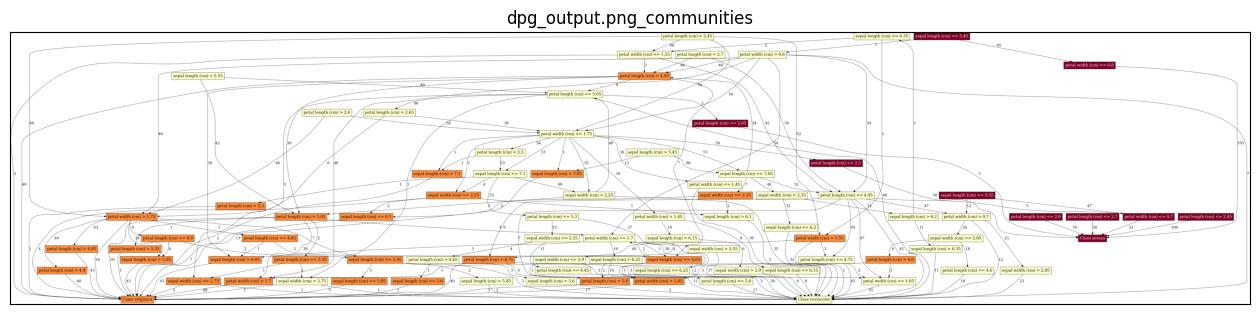

In [3]:
dpg = DecisionPredicateGraph(
    model=model,
    feature_names=iris.feature_names,
    target_names= iris.target_names
,
    perc_var=0.0001,
    decimal_threshold=2,
    n_jobs=1
)
dot = dpg.fit(X)
dpg_model, nodes_list = dpg.to_networkx(dot)

dpg_metrics = dpg.extract_graph_metrics(dpg_model, nodes_list)
df_nodes = dpg.extract_node_metrics(dpg_model, nodes_list)

plot_dpg("dpg_output.png", dot, df_nodes, dpg_metrics, save_dir="../datasets", communities=True, class_flag=False)

In [4]:
import pandas as pd

# Assuming dpg_metrics is already defined and contains "Class Bounds"
class_bounds = dpg_metrics.get("Class Bounds", {})

# Convert to DataFrame: one row per class with constraints joined
df_bounds = pd.DataFrame([
    {"Class": class_name, "Constraints": ", ".join(sorted(bounds))}
    for class_name, bounds in class_bounds.items()
])

# Optional: sort alphabetically by class name
df_bounds = df_bounds.sort_values("Class")
print(df_bounds)


              Class  \
2      Class setosa   
0  Class versicolor   
1   Class virginica   

                                                                                                                         Constraints  
2         0.8 < petal width (cm) <= 1.75, 2.45 < petal length (cm) <= 5.05, 5.45 < sepal length (cm) <= 7.1, sepal width (cm) > 2.25  
0  0.7 < petal width (cm) <= 1.75, 2.25 < sepal width (cm) <= 2.9, 2.45 < petal length (cm) <= 5.35, 5.45 < sepal length (cm) <= 7.1  
1  0.7 < petal width (cm) <= 1.75, 2.25 < sepal width (cm) <= 2.9, 2.45 < petal length (cm) <= 5.35, 5.45 < sepal length (cm) <= 7.1  


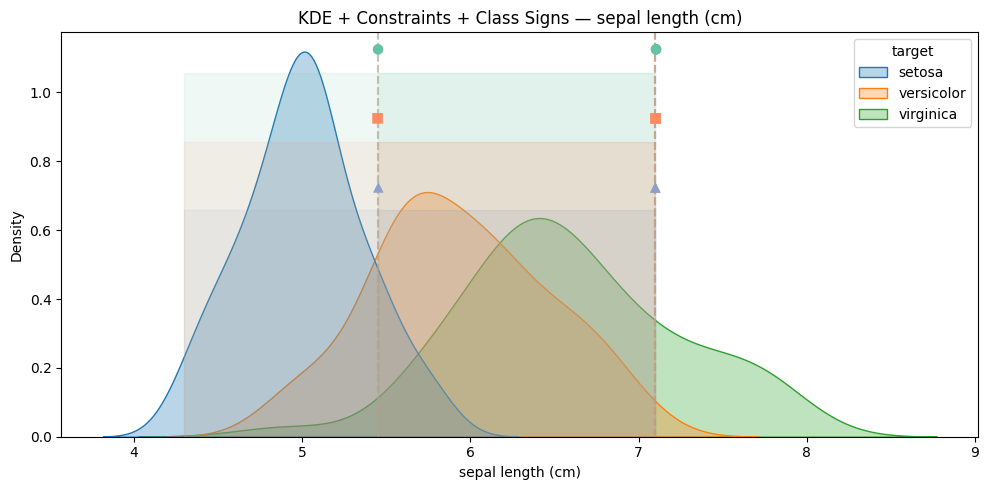

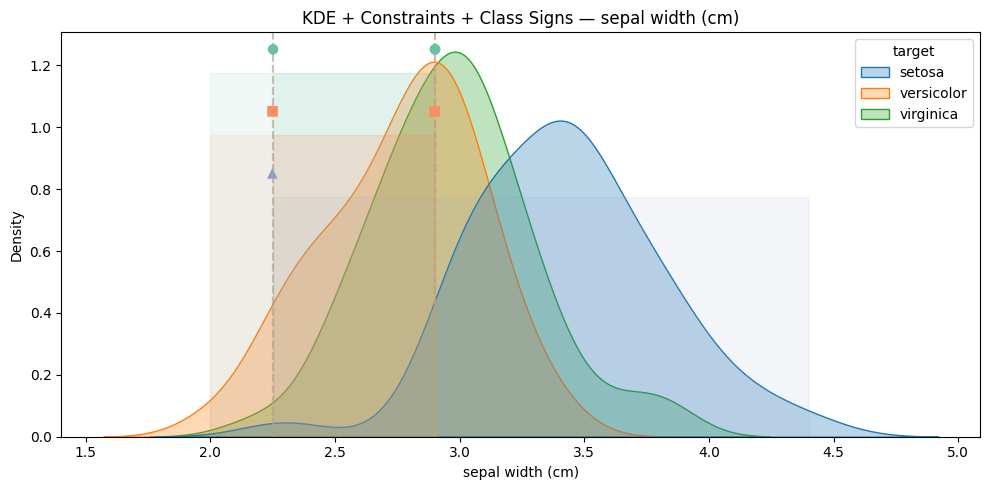

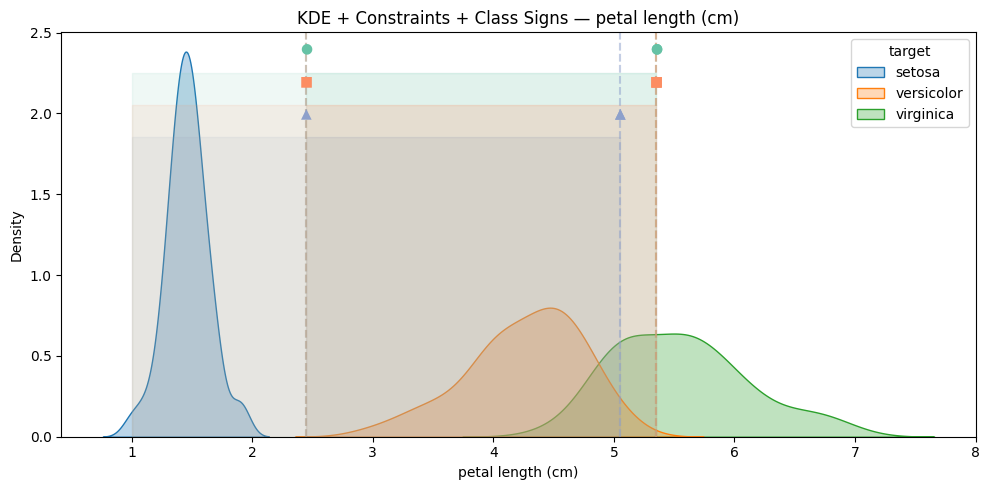

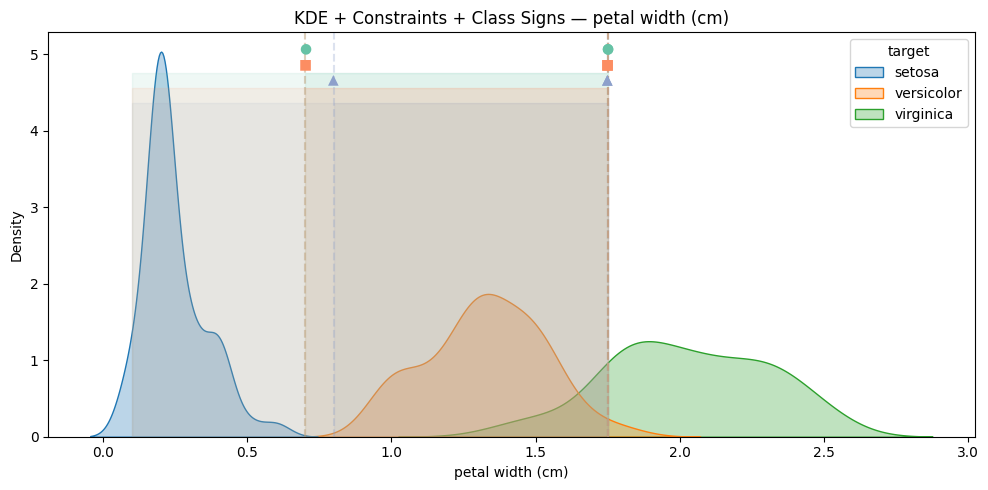

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import pandas as pd
import re

# Load Iris dataset
iris = load_iris(as_frame=True)
df_iris = iris.frame
df_iris["target"] = df_iris["target"].apply(lambda x: iris.target_names[x])

# Define signs per class
class_signs = {
    "setosa": "▲",
    "versicolor": "●",
    "virginica": "■"
}

# Extract actual features from the dataset
available_features = df_iris.columns[:-1].tolist()
palette = sns.color_palette("Set2", n_colors=len(df_bounds))

for feature in available_features:
    plt.figure(figsize=(10, 5))
    ax = sns.kdeplot(data=df_iris, x=feature, hue="target", fill=True, common_norm=False, alpha=0.3)
    plt.title(f"KDE + Constraints + Class Signs — {feature}")
    plt.xlabel(feature)
    plt.ylabel("Density")

    feature_min, feature_max = df_iris[feature].min(), df_iris[feature].max()

    for i, row in df_bounds.iterrows():
        class_label = row["Class"].replace("Class ", "")
        constraints = row["Constraints"]
        sign = class_signs.get(class_label, "")
        color = palette[i % len(palette)]

        # Handle bounded ranges: a < feature <= b
        matches_range = re.findall(rf"([\d\.-]+) < {re.escape(feature)} <= ([\d\.-]+)", constraints)
        for lower, upper in matches_range:
            lower, upper = float(lower), float(upper)
            plt.axvline(lower, color=color, linestyle="--", alpha=0.3)
            plt.axvline(upper, color=color, linestyle="--", alpha=0.3)
            plt.fill_betweenx([0, plt.ylim()[1]*0.9+(i*-0.2)], lower, upper, color=color, alpha=0.1)
            plt.text(lower, plt.ylim()[1]*0.95+(i*-0.2), sign, color=color, ha='center')
            plt.text(upper, plt.ylim()[1]*0.95+(i*-0.2), sign, color=color, ha='center')

        # Handle lower-bound only: feature > a
        matches_gt = re.findall(rf"{re.escape(feature)} > ([\d\.-]+)", constraints)
        for lower in matches_gt:
            lower = float(lower)
            plt.axvline(lower, color=color, linestyle="--", alpha=0.3)
            plt.fill_betweenx([0, plt.ylim()[1]*0.9+(i*-0.2)], lower, feature_max, color=color, alpha=0.1)
            plt.text(lower, plt.ylim()[1]*0.95+(i*-0.2), sign, color=color, ha='center')

        # Handle upper-bound only: feature <= b
        matches_le = re.findall(rf"{re.escape(feature)} <= ([\d\.-]+)", constraints)
        for upper in matches_le:
            upper = float(upper)
            plt.axvline(upper, color=color, linestyle="--", alpha=0.3)
            plt.fill_betweenx([0, plt.ylim()[1]*0.9+(i*-0.2)], feature_min, upper, color=color, alpha=0.1)
            plt.text(upper, plt.ylim()[1]*0.95+(i*-0.2), sign, color=color, ha='center')

    plt.tight_layout()
    plt.show()
